# Mobile Air Quality Monitoring in the Salt Lake Valley
## Exploratory Notebook

COMP 5960: Applied Data Visualization Final Project -- Fall 2023

Authors: Tony Le (u1368721), Adrian Martino (u1431239), John Stevens (u1117706)

GitHub Repository: https://github.com/anth0nyhle/MobileAirQualitySLV

Date: 19 November 2023

### 1.0 Data

Archived historical raw data (compressed CSV files) from research-grade pollutant sensors on 3 light-trail cars, traveling on the Red, Green, and Blue UTA TRAX lines in the SLV, have been provided by Drs. Alex Jacques and Daniel Mendoza, research scientists in the Department of Atmospheric Sciences at the University of Utah ([UTA TRAX](https://utahaq.chpc.utah.edu/aq/historical_archive/UTA_TRAX/); [UTA EBUS](https://utahaq.chpc.utah.edu/aq/historical_archive/UTA_EBUS/)). This dataset is part of an ongoing mobile air quality monitoring project called the TRAX Observation Project ([MesoWest Utah Air Quality Observations](https://utahaq.chpc.utah.edu/aq/cgi-bin/mobile_data.cgi)) and includes GPS positioning, train-top ambient temperature and humidity, PM2.5 measurements from a Met One ES-642 Dust Monitor, and ozone measurements from a 2B Technologies 205 Ozone Monitor. We also include archived historical raw data from 7 e-buses, traveling around in the SLV.

* TRAX train 1 (TRX01) samples data along the Red and Green lines, beginning November 2018 to present.
* TRAX train 2 (TRX02) samples data along the Red and Green lines, beginning November 2018 to present.
* TRAX train 3 (TRX03) samples data along the Blue line, beginning November 2019 to present.
* E-Bus 1 (BUS01) samples data along , beginning September 2021 to present.
* E-Bus 2 (BUS02) samples data along , beginning February 2022 to present.
* E-Bus 3 (BUS03) samples data along , beginning February 2022 to present.
* E-Bus 4 (BUS04) samples data along , beginning May 2023 to present.
* E-Bus 5 (BUS05) samples data along , beginning July 2023 to present.
* E-Bus 6 (BUS06) samples data along , beginning September 2023 to present.
* E-Bus 7 (BUS07) samples data along , beginning September 2023 to present.

For all transits, the PM2.5 and Ozone data were sampled every 2 seconds everyday of operation. We used data from when the sensors were installed through September 2023. Note: E-Bus 6 and 7 did not have any valid data collected during September 2023.

Socioeconomic demographic data, such as race and ethnicity distribution, median household income, per capita income, and housing value – all by zip code tabulation area (ZCTA) within Utah, were obtained from the [US Census Bureau](https://data.census.gov/). Cartographic boundary shapefiles of US ZCTAs for plotting the zip code area geometries were also gathered from the US Census Bureau ([TIGER/Line Shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html)).

### 2.0 Data Grooming & Wrangling

#### 2.1 Air Quality Data Grooming & Wrangling

All the pollutant sensor sampled measurements from each instrument every 2 seconds, every day from 2018 to 2023. Therefore, we needed to groom and downsample the raw data. There were numerous automated and manually reviewed data quality checks applied to the archived historical data to help remove potentially suspicious or inaccurate observations. The following checks have been performed on this dataset: 

1. Data was omitted entirely if it was determined that the train car was located inside a UTA maintenance depot or if the GPS was malfunctioning; 
2. PM2.5 concentrations were set to -9999 if the sensor air flow rate fell below 1.5 L/min or if the concentrations did not pass an unphysical high-frequency noise test; 
3. Ozone concentrations were set to -9999 if the sensor air flow rate fell below 1.5 L/min or if the concentrations did not pass an unphysical high-frequency noise test; 
4. PM2.5_Data_Flagged was set to 1 if the ES-642 produced an error code, if the sensor internal relative humidity exceeded 50%, or if the ambient train-top relative humidity exceeded 70%; and 
5. Ozone_Data_Flagged was set to 1 if the sensor internal temperature or installation unit exceeded 50 degrees C.

In [1]:
import os
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import geopandas as gpd
import csv
from geopy.distance import geodesic
import numpy as np
from matplotlib.colors import ListedColormap
import contextily as cx
import mapclassify
import palettable
import folium
import seaborn as sns
from shapely.geometry import Point


Based on the checks listed above, we removed any observations with PM2.5 or ozone concentrations set to -9999 or with any GPS recordings (latitude or longitude) set to -9999.

We added a few air quality categories to the data as columns including:
* AQI Category: Air Quality Index -- a descriptive scale based on PM2.5 concentrations
* PM2.5 Category: a scale that bins PM2.5 concentrations
* MesoWest Category: bins determined by the MesoWest AirQuality team

Creating these catagories was instrumental in helping visualize the AQ across the valley. We initially were visualizing the data using the categories with fewer bins and only when we switched to more, narrowly defined bins did patterns start to emerge. The last one, Meso_West_Category, is using the categories that the Meso West AQ team uses in their visualizations and, without doing a separate, full analysis of our own on this, itseems like the best way to bin the PM2.5 data.

We also extracted several time and date features from the data as columns including:
* Year
* Month
* Day of year
* Day of month
* Hour
* Minute

In [ ]:
# No need to run this code block if groomed data is already available
raw_data_path = './raw_data/'  # Path to raw data stored locally
gmd_data_path = './data/aq_data/'  # Path to groomed data

AQI_category = CategoricalDtype(categories=["Good", "Moderate", "Unhealthy for Sensitive Groups", 
                                            "Unhealthy", "Very Unhealthy", "Hazardous"], ordered=True)
PM25_Category = CategoricalDtype(categories=["< 12.00", "12.00 - 35.50", "35.50 - 85.50", 
                                                "115.00 - 150.50", "150.50+"], ordered=True)
MesoWest_Category = CategoricalDtype(categories=['< 2.00', '2.00 - 4.00', '4.00 - 6.00', 
                                                    '6.00 - 8.00', '8.00 - 10.00','10.00 - 12.00',
                                                    '12.00 - 20.00','20.00 - 28.00','28.00 - 35.50',
                                                    '35.50 - 45.50','45.50 - 55.50','55.50 - 85.50',
                                                    '85.50 - 115.50','115.50 - 150.50','150.50+'], ordered=True)

All raw data files were stored locally. Once the raw data was groomed by the code block below, the groomed data files were stored and pushed to the remote GitHub repository for collaboration.

In code block below, we groomed the raw data by:
1. Reading in each raw data file
2. Extracted the transit ID from the filename
3. Combined the existing headers with their respective unit of measurement listed in the second row (e.g., Latitude_ddeg)
4. Extracted time and data features from the timestamp column (e.g., Year, Month, Day of year, Day of month, Hour, Minute)
5. Added the categorical columns based on PM2.5 concentration values (e.g., AQI Category, PM2.5 Category, MesoWest Category)
6. Removed any observations with PM2.5 or ozone concentrations set to -9999 or with any GPS recordings (latitude or longitude) set to -9999
7. Downsampled the data to every 30 observations (1 minute)
8. Saved the groomed data to a new CSV file to save remotely

In [ ]:
# No need to run this code block if groomed data is already available
for filename in os.listdir(raw_data_path):
    if filename.endswith('.csv'):
        raw_file_path = os.path.join(raw_data_path, filename)
        gmd_file_path = os.path.join(gmd_data_path, filename)
        transit_id = filename.split('_')[0]
        transit_df = pd.read_csv(raw_file_path, low_memory=False)

        headers = transit_df.columns.to_list()
        units = transit_df.iloc[0].to_list()

        new_headers = [f'{h}_{u}' for h, u in zip(headers, units)]

        transit_df = transit_df.iloc[1:].reset_index(drop=True)
        transit_df.columns = pd.Index(new_headers)
        transit_df['Timestamp_UTC'] = pd.to_datetime(
            transit_df['Timestamp_UTC'])
        transit_df.iloc[:, 1:-2] = transit_df.iloc[:, 1:-2].astype(float)

        transit_df['Time_Tuple'] = transit_df['Timestamp_UTC'].apply(
            lambda x: x.timetuple())
        transit_df['Date'] = transit_df['Timestamp_UTC'].apply(
            lambda x: x.date())
        transit_df['Year'] = transit_df['Timestamp_UTC'].apply(
            lambda x: x.timetuple().tm_year)
        transit_df['Month'] = transit_df['Timestamp_UTC'].apply(
            lambda x: x.timetuple().tm_mon)
        transit_df['Day_of_Year'] = transit_df['Timestamp_UTC'].apply(
            lambda x: x.timetuple().tm_yday)
        transit_df['Day_of_Month'] = transit_df['Timestamp_UTC'].apply(
            lambda x: x.timetuple().tm_mday)
        transit_df['Minute'] = transit_df['Timestamp_UTC'].apply(
            lambda x: x.timetuple().tm_min)
        transit_df['Hour'] = transit_df['Timestamp_UTC'].apply(
            lambda x: x.timetuple().tm_hour)
        transit_df['Transit_ID'] = transit_id
        
        pm25_cols = transit_df.filter(like='PM2.5_Concentration_ug/m3')
        ozone_cols = transit_df.filter(like='Ozone_Concentration_ppbv')
        
        aqi_col = pm25_cols.applymap(lambda x: 'Good' if x < 12
                                            else ('Moderate' if x < 35.5
                                                  else ('Unhealthy for Sensitive Groups' if x < 55.5
                                                        else ('Unhealthy' if x < 150.5
                                                              else ('Very Unhealthy' if x < 250.5 else 'Hazardous')))))

        pm25_category_col = pm25_cols.applymap(lambda x: '< 12.00' if x < 12.00
                                                       else ('12.00 - 35.50' if x < 35.50
                                                             else ('35.50 - 85.50' if x < 85.50
                                                                else ('115.00 - 150.50') if x < 150.50
                                                                else ('150.50+'))))


        meso_west_category_col = pm25_cols.applymap(lambda x: '< 2.00' if x < 2.00
                                                           else ('2.00 - 4.00' if x < 4.00
                                                                 else ('4.00 - 6.00' if x < 6.00
                                                                      else ('6.00 - 8.00') if x < 8.00
                                                                      else ('8.00 - 10.00') if x < 10.00
                                                                      else ('10.00 - 12.00') if x < 12.00
                                                                      else ('12.00 - 20.00') if x < 20.00
                                                                      else ('20.00 - 28.00') if x < 28.00
                                                                      else ('28.00 - 35.50') if x < 35.50
                                                                      else ('35.50 - 45.50') if x < 45.50
                                                                      else ('45.50 - 55.50') if x < 55.50
                                                                      else ('55.50 - 85.50') if x < 85.50
                                                                      else ('85.50 - 115.50') if x < 115.50
                                                                      else ('115.50 - 150.50') if x < 150.50
                                                                      else ('150.50+'))))
        
        transit_df['AQI'] = aqi_col
        transit_df['PM2.5_Category'] = pm25_category_col
        transit_df['Meso_West_Category'] = meso_west_category_col

        transit_df['AQI'] = transit_df['AQI'].astype(AQI_category)
        transit_df['PM2.5_Category'] = transit_df['PM2.5_Category'].astype(PM25_Category)
        transit_df['Meso_West_Category'] = transit_df['Meso_West_Category'].astype(MesoWest_Category)

        transit_df_filt = transit_df[
            (pm25_cols != -9999.00).all(axis=1) &
            (ozone_cols != -9999.00).all(axis=1) &
            (transit_df['Latitude_ddeg'] != -9999.00) &
            (transit_df['Longitude_ddeg'] != -9999.00)]

        transit_df_gmd = transit_df_filt.iloc[::30, :].reset_index(drop=True)
        transit_df_gmd.to_csv(gmd_file_path, index=False)
        print(f'Groomed: {filename}')

Once the raw data was groomed, we aggregated and combined the data based on transit ID. For example, all the data for the TRAX train 1 (TRX01) was combined into a single dataframe and saved as a csv file for later use. However, since these files were too large to push to the remote GitHub repository, we saved them locally.

In [ ]:
# No need to run this code block if transit dataframes are already available
data_path = './data/aq_data/'
filenames = os.listdir(data_path)

transit_ids = [fn.split('_')[0] for fn in filenames]
transit_ids = set(transit_ids)

transit_ids = sorted(list(transit_ids))

In [ ]:
# No need to run this code block if transit dataframes are already available
for id in transit_ids:
    combined_df = pd.DataFrame()
    transit_files = [fn for fn in filenames if fn.startswith(id)]
    
    for i, f in enumerate(transit_files):
        file_path = os.path.join(data_path, f)
        if i == 0:
            df = pd.read_csv(file_path, low_memory=False, header=None)
        else:
            df = pd.read_csv(file_path, low_memory=False, header=None)
            df = df.drop(df.index[0])
        combined_df = pd.concat([combined_df, df], axis=0, ignore_index=True)    
    
    # combined_df.columns = combined_df.iloc[0]
    # combined_df = combined_df.drop(combined_df.index[0])
    # combined_df = combined_df[1:].reset_index(drop=True)
    
    id_df_filename = './data/transit_dfs/' + id + '_df.csv'
    combined_df.to_csv(id_df_filename, index=False)
    print('Combined df for ' + id + ' data saved. Size = ' + str(combined_df.shape))

#### 2.2 Zip Code Tabulation Area (ZCTA) Data Grooming & Wrangling

We downloaded the ZCTA shapefiles from the US Census Bureau, which included all ZCTA in the US. We then filtered the shapefile to only include ZCTA in Salt Lake County, Utah, renamed the header for ZCTA from ZCTA5CE20 to just ZCTA5, and saved the filtered shapefile as a new shapefile to be used in visualizations.

In [ ]:
# No need to run this code block if filtered shapefile for Salt Lake County is already available
us_zcta_path = './zcta_data/tl_rd22_us_zcta520.shp'
us_zcta_data = gpd.read_file(us_zcta_path)
us_zcta_data['ZCTA5CE20'] = us_zcta_data['ZCTA5CE20'].astype(int)

In [ ]:
# No need to run this code block if filtered shapefile for Salt Lake County is already available
slc_zcta_list_path = './zcta_data/slc_zcta.csv'
slc_zcta_list = []

with open(slc_zcta_list_path, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        int_row = [int(i) for i in row]
        slc_zcta_list.append(int_row)
        
slc_zcta_list = [item for sublist in slc_zcta_list for item in sublist]

In [ ]:
# No need to run this code block if filtered shapefile for Salt Lake County is already available
slc_zcta_data = us_zcta_data[us_zcta_data['ZCTA5CE20'].isin(slc_zcta_list)]
slc_zcta_data = slc_zcta_data.rename(columns={'ZCTA5CE20': 'ZCTA5'})

#### 2.2.1 Salt Lake County ZCTA Map

(-112.2955674, -111.51783660000001, 40.404954000000004, 40.946462)

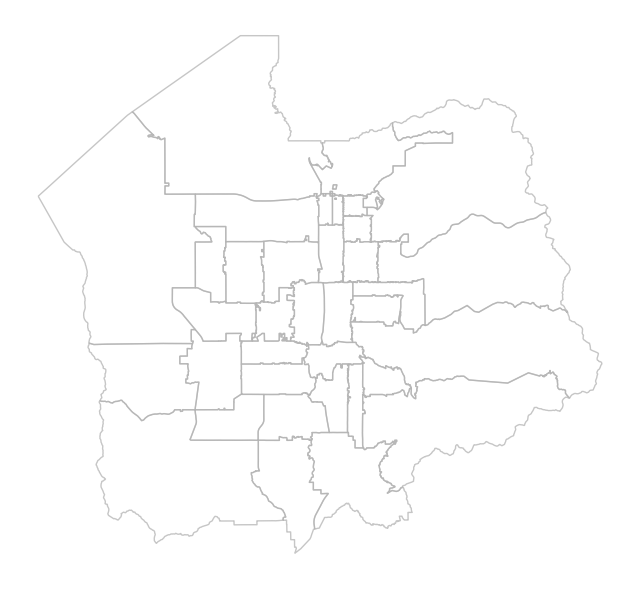

In [2]:
slc_shapefile_path = 'zcta_data/slc_zcta.shp'
slc_gdf = gpd.read_file(slc_shapefile_path)

fig, ax = plt.subplots(figsize=(8, 12))
slc_gdf.plot(ax=ax, linewidth=1.0, edgecolor='0.7', alpha=0.75, facecolor='none')
plt.axis('off')

#### 2.3 Socioeconomic Demographic Data Grooming & Wrangling

Socioeconomic demographic data for the Salt Lake County by ZCTA were downloaded from the US Census Bureau, transposed, and saved as CSV files with ZCTA as the index and columns slightly modified.

In [3]:
import numpy as np

In [4]:
def process_data(df_path):
    df = pd.read_csv(df_path)
    df = df.T
    df.columns = df.iloc[0]
    df = df[1:]
    df = df.reset_index()
    df = df.rename(columns={'index': 'ZCTA5'})
    df = df.rename_axis(None, axis=1)
    df = df[~df['ZCTA5'].str.contains('Margin of Error')]
    df['ZCTA5'] = df['ZCTA5'].str.replace('!!Estimate', '')
    df['ZCTA5'] = df['ZCTA5'].str.replace('ZCTA5 ', '')
    return df

#### 2.3.1 Race & Ethnicity Data by ZCTA

In [5]:
race_path = './data/census_data/ACSDT5Y2021.B02001-2023-10-31T173111.csv'

race_pop_df = process_data(race_path)
race_pop_df.to_csv('./data/census_data/race_pop_df.csv', index=False)
#race_pop_df.head()

#### 2.3.2 Race & Ethnicity Data for Latino or Hispanic Origin or non-Latino or Hispanic Origin by ZCTA

In [6]:
race_by_latino_path = './data/census_data/DECENNIALDHC2020.P9-2023-11-14T190515.csv'

race_pop_by_latino_df = process_data(race_by_latino_path)
race_pop_by_latino_df.to_csv('./data/census_data/race_pop_by_latino_df.csv', index=False)
#race_pop_by_latino_df.head()

#### 2.3.4 Income Bracket Data by ZCTA 

In [7]:
income_brac_path = './data/census_data/ACSDT5Y2021.B19001-2023-10-31T171319.csv'

income_brac_df = process_data(income_brac_path)
income_brac_df.to_csv('./data/census_data/income_brac_df.csv', index=False)
#income_brac_df.head()

#### 2.3.5 Median Household Income Data by ZCTA

In [8]:
median_hh_income_path = './data/census_data/ACSDT5Y2021.B19013-2023-10-31T171430.csv'

median_hh_income_df = process_data(median_hh_income_path)
median_hh_income_df.to_csv('./data/census_data/median_hh_income_df.csv', index=False)
#median_hh_income_df.head()

#### 2.3.6 Per Capita Income Data by ZCTA

In [9]:
per_cap_income = './data/census_data/ACSDT5Y2021.B19301-2023-10-31T171519.csv'

per_cap_income_df = process_data(per_cap_income)
per_cap_income_df.to_csv('./data/census_data/per_cap_income_df.csv', index=False)
#per_cap_income_df.head()

In [10]:
median_house_value = './data/census_data/ACSDT5Y2021.B25077-2023-10-31T172542.csv'

median_house_value_df = process_data(median_house_value)
median_house_value_df.to_csv('./data/census_data/median_house_value_df.csv', index=False)
#median_house_value_df.head()

### 3.0 Socioeconomic Demographic Data Maps

In [11]:
slc_zcta_list_path = './zcta_data/slc_zcta.csv'

slc_zcta_list = []

with open(slc_zcta_list_path, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        int_row = [int(i) for i in row]
        slc_zcta_list.append(int_row)
        
slc_zcta_list = [item for sublist in slc_zcta_list for item in sublist]

#### 3.1 Race & Ethnicity Maps

In [12]:
# Load the race population data
race_pop_path = './data/census_data/race_pop_by_latino_df.csv'
race_pop_df = pd.read_csv(race_pop_path)
race_pop_df = race_pop_df[race_pop_df['ZCTA5'].isin(slc_zcta_list)]
# df.columns = race_pop_df.columns.str.replace('\t', '')
race_pop_df.columns = race_pop_df.columns.str.strip()
race_pop_df = race_pop_df.replace(',','', regex=True)
race_pop_df = race_pop_df.astype(int)
race_pop_df = race_pop_df.reset_index(drop=True)

race_pop_df['Perc_Hispanic_Latino'] = round((race_pop_df['Hispanic or Latino'] / race_pop_df['Total:'])*100, 1)
race_pop_df['Perc_Black'] = round((race_pop_df['Black or African American alone'] / race_pop_df['Total:'])*100, 1)
race_pop_df['Perc_NonWhite'] = round(((race_pop_df['Total:'] - race_pop_df['White alone']) / race_pop_df['Total:'])*100, 1)

In [13]:
race_pop_gdf = slc_gdf.merge(race_pop_df, left_on='ZCTA5', right_on='ZCTA5')

#### 3.1.1 Percent Latino or Hispanic Origin by ZCTA

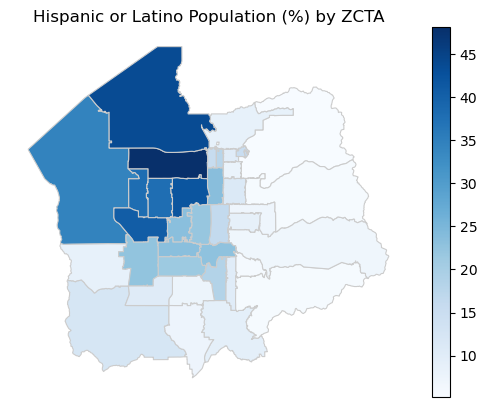

In [14]:
race_pop_gdf.plot(column='Perc_Hispanic_Latino', cmap='Blues', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Hispanic or Latino Population (%) by ZCTA')
plt.axis('off')
plt.show()

#### 3.1.2 Percent Black or African-American by ZCTA

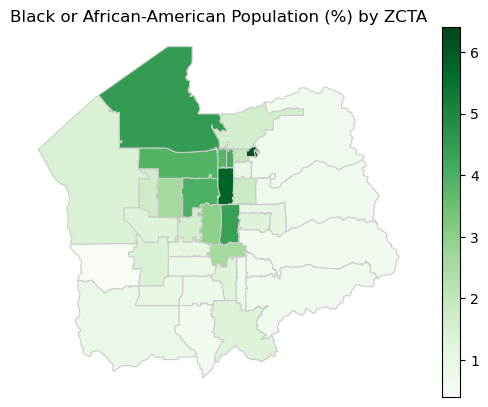

In [15]:
race_pop_gdf.plot(column='Perc_Black', cmap='Greens', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Black or African-American Population (%) by ZCTA')
plt.axis('off')
plt.show()

#### 3.1.3 Percent Minority (Non-White) by ZCTA

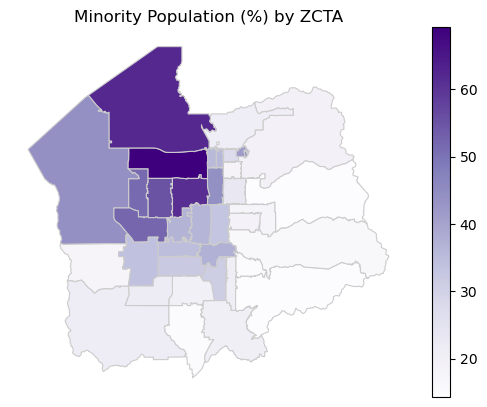

In [16]:
race_pop_gdf.plot(column='Perc_NonWhite', cmap='Purples', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Minority Population (%) by ZCTA')
plt.axis('off')
plt.show()

#### 3.2 Income & Housing Maps

#### 3.2.1 Income Bracket by ZCTA

In [17]:
# Load the income bracket data
income_brac_path = './data/census_data/income_brac_df.csv'
income_brac_df = pd.read_csv(income_brac_path)
income_brac_df = income_brac_df[income_brac_df['ZCTA5'].isin(slc_zcta_list)]
income_brac_df.columns = income_brac_df.columns.str.strip()
income_brac_df = income_brac_df.replace(',','', regex=True)
income_brac_df = income_brac_df.astype(int)
income_brac_df = income_brac_df.reset_index(drop=True)

In [18]:
income_brac_gdf = slc_gdf.merge(income_brac_df, left_on='ZCTA5', right_on='ZCTA5')

#### 3.2.2 Median Household Income by ZCTA

In [19]:
# Load the median household income data
median_hh_income_path = './data/census_data/median_hh_income_df.csv'
median_hh_income_df = pd.read_csv(median_hh_income_path)
median_hh_income_df = median_hh_income_df[median_hh_income_df['ZCTA5'].isin(slc_zcta_list)]
median_hh_income_df.columns = median_hh_income_df.columns.str.strip()
median_hh_income_df = median_hh_income_df.replace(',','', regex=True)
median_hh_income_df = median_hh_income_df.replace('-', np.nan)
median_hh_income_df = median_hh_income_df.rename(columns={'Median household income in the past 12 months (in 2021 inflation-adjusted dollars)': 'Median_HH_Income'})
median_hh_income_df['Median_HH_Income'] = median_hh_income_df['Median_HH_Income'].astype(float)
median_hh_income_df = median_hh_income_df.reset_index(drop=True)

In [20]:
median_hh_income_gdf = slc_gdf.merge(median_hh_income_df, left_on='ZCTA5', right_on='ZCTA5')

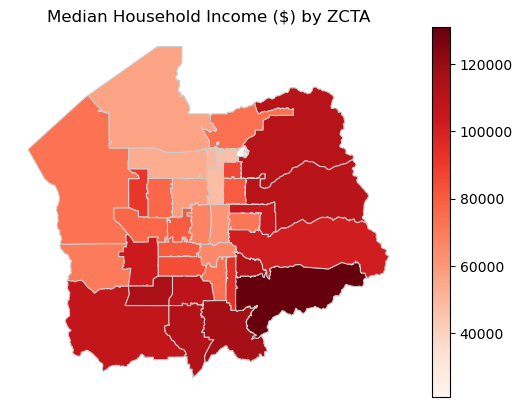

In [21]:
median_hh_income_gdf.plot(column='Median_HH_Income', cmap='Reds', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Median Household Income ($) by ZCTA')
plt.axis('off')
plt.show()

#### 3.2.3 Housing Value by ZCTA

In [22]:
# Load median house value data
house_value_path = './data/census_data/median_house_value_df.csv'
house_value_df = pd.read_csv(house_value_path)
house_value_df = house_value_df[house_value_df['ZCTA5'].isin(slc_zcta_list)]
house_value_df.columns = house_value_df.columns.str.strip()
house_value_df = house_value_df.replace(',','', regex=True)
house_value_df = house_value_df.replace('-', np.nan)
house_value_df = house_value_df.rename(columns={'Median value (dollars)': 'Median_House_Value'})
house_value_df['Median_House_Value'] = house_value_df['Median_House_Value'].astype(float)
house_value_df = house_value_df.reset_index(drop=True)

In [23]:
house_value_gdf = slc_gdf.merge(house_value_df, left_on='ZCTA5', right_on='ZCTA5')

In [24]:
house_value_gdf.plot(column='Median_House_Value', cmap='Oranges', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Housing Value ($) by ZCTA')
plt.axis('off')
plt.show()

#### 3.2.4 Per Captia Income by ZCTA

In [25]:
# Load per captia income data
per_cap_income_path = './data/census_data/per_cap_income_df.csv'
per_cap_income_df = pd.read_csv(per_cap_income_path)
per_cap_income_df = per_cap_income_df[per_cap_income_df['ZCTA5'].isin(slc_zcta_list)]
per_cap_income_df.columns = per_cap_income_df.columns.str.strip()
per_cap_income_df = per_cap_income_df.replace(',','', regex=True)
per_cap_income_df = per_cap_income_df.replace('-', np.nan)
per_cap_income_df = per_cap_income_df.rename(columns={'Per capita income in the past 12 months (in 2021 inflation-adjusted dollars)': 'Per_Capita_Income_Value'})
per_cap_income_df['Per_Capita_Income_Value'] = per_cap_income_df['Per_Capita_Income_Value'].astype(float)
per_cap_income_df = per_cap_income_df.reset_index(drop=True)

In [26]:
per_cap_income_gdf = slc_gdf.merge(per_cap_income_df, left_on='ZCTA5', right_on='ZCTA5')

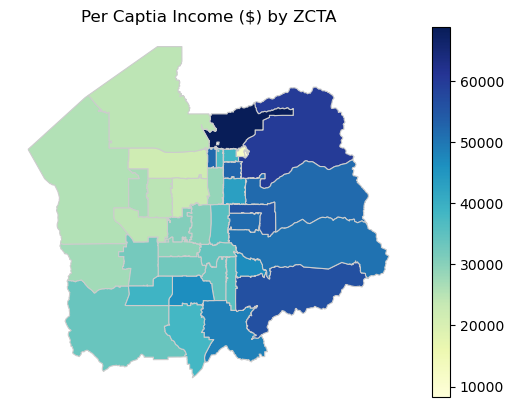

In [27]:
per_cap_income_gdf.plot(column='Per_Capita_Income_Value', cmap='YlGnBu', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Per Captia Income ($) by ZCTA')
plt.axis('off')
plt.show()

#### 4.0 Air Quality Data Maps & Graphs

#### 4.1 Air Quality Monitored by E-Buses, Aggregated by Year

We first graphed the bus data to see what it looked like (see image below). The code for this has since been lost, but thats ok because we ended up taking a different route.

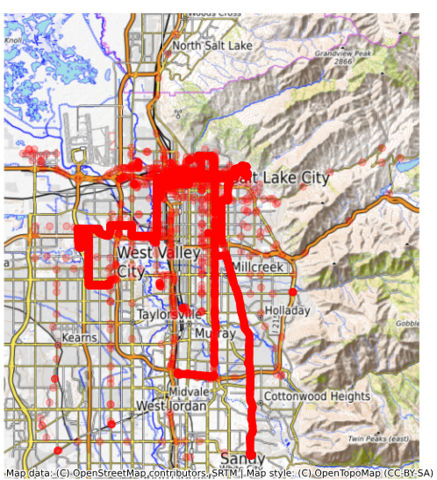

After realizing that the buses seem to take the same routes every day and wouldn't give us comprehensive enough coverage of the valley to make a heat map with, we decided to look into other options. First, we were curious to see if there was a big disparity in air quality east to west on average, so we wrote up some code to check that.

Here is a bunch of data wrangling code (commented out so you won't run it) :

In [28]:
#combine all files into one big df

# #Manually go into each df and delete the firs row that is ',0,1,2,3,4,...'
# df1 = pd.read_csv('./data/transit_dfs/BUS01_df.csv')
# df2 = pd.read_csv('./data/transit_dfs/BUS02_df.csv')
# df3 = pd.read_csv('./data/transit_dfs/BUS03_df.csv')
# df4 = pd.read_csv('./data/transit_dfs/BUS04_df.csv')
# df5 = pd.read_csv('./data/transit_dfs/BUS05_df.csv')
# df6 = pd.read_csv('./data/transit_dfs/BUS06_df.csv')
# #df7 = pd.read_csv('./data/transit_dfs/BUS07_df.csv') theres nothing in this csv
# df8 = pd.read_csv('./data/transit_dfs/TRX01_df.csv')
# df9 = pd.read_csv('./data/transit_dfs/TRX02_df.csv')
# df10 = pd.read_csv('./data/transit_dfs/TRX03_df.csv')

# #df4.rename(columns={'ES405_PM1_Concentration_ug/m3':'ES642_PM2.5_Concentration_ug/m3'}, inplace=True)
# df5.rename(columns={'ES405_PM1_Concentration_ug/m3':'ES642_PM2.5_Concentration_ug/m3'}, inplace=True)
# df6.rename(columns={'ES405_PM1_Concentration_ug/m3':'ES642_PM2.5_Concentration_ug/m3'}, inplace=True)

# bigDF = pd.concat([df1, df2, df3, df4, df5, df6, df8, df9, df10])

# #get just the rows we want
# df = bigDF[['Timestamp_UTC','Latitude_ddeg','Longitude_ddeg','Elevation_m','ES642_PM2.5_Concentration_ug/m3','Time_Tuple','Date','Year','Month','Day_of_Year','Day_of_Month','Minute','Hour','Transit_ID','AQI','PM2.5_Category','Meso_West_Category']]
# df.to_csv('./data/transit_dfs/AllDF.csv')


Then I created two charts, one showing east vs west air quality over time when dividing along state street and one that divides along 300 west.
(Again because its working on a massive data frame I made with like 4.5 million rows, I'll just include screenshots of the created graphs)

In [29]:
# # create east and west data frames along state street
# df = pd.read_csv('./data/transit_dfs/compressedAllDF.csv')
# westDF = df[df['Longitude_ddeg'] < -111.888245]
# eastDF = df[df['Longitude_ddeg'] >= -111.888245]

# west_monthly_avg = westDF.groupby(['Year', 'Month'])['ES642_PM2.5_Concentration_ug/m3'].mean().reset_index()
# east_monthly_avg = eastDF.groupby(['Year', 'Month'])['ES642_PM2.5_Concentration_ug/m3'].mean().reset_index()
# east_monthly_avg['Month'] = pd.to_datetime(east_monthly_avg[['Year', 'Month']].assign(DAY=1))
# west_monthly_avg['Month'] = pd.to_datetime(west_monthly_avg[['Year', 'Month']].assign(DAY=1))
# combined_monthly_avg = pd.concat([east_monthly_avg, west_monthly_avg], keys=['East', 'West'])
# plt.figure(figsize=(20, 6))
# for region, data in combined_monthly_avg.groupby(level=0):
#     plt.plot(data['Month'], data['ES642_PM2.5_Concentration_ug/m3'], label=region, linestyle='-')

# plt.title('State Street Divide')
# plt.xlabel('Year')
# plt.ylabel('Average Concentration (ug/m3)')
# plt.legend()
# plt.grid(True)
# plt.show()

# #Here is if instead of a dividing along state street, we divided along 300 west
# westDF = df[df['Longitude_ddeg'] < -111.899664]
# eastDF = df[df['Longitude_ddeg'] >= -111.899664]
# west_monthly_avg = westDF.groupby(['Year', 'Month'])['ES642_PM2.5_Concentration_ug/m3'].mean().reset_index()
# east_monthly_avg = eastDF.groupby(['Year', 'Month'])['ES642_PM2.5_Concentration_ug/m3'].mean().reset_index()
# east_monthly_avg['Month'] = pd.to_datetime(east_monthly_avg[['Year', 'Month']].assign(DAY=1))
# west_monthly_avg['Month'] = pd.to_datetime(west_monthly_avg[['Year', 'Month']].assign(DAY=1))
# combined_monthly_avg = pd.concat([east_monthly_avg, west_monthly_avg], keys=['East', 'West'])
# plt.figure(figsize=(20, 6))
# for region, data in combined_monthly_avg.groupby(level=0):
#     plt.plot(data['Month'], data['ES642_PM2.5_Concentration_ug/m3'], label=region, linestyle='-')

# plt.title('300 West Divide')
# plt.xlabel('Year')
# plt.ylabel('Average Concentration (ug/m3)')
# plt.legend()
# plt.grid(True)
# plt.show()

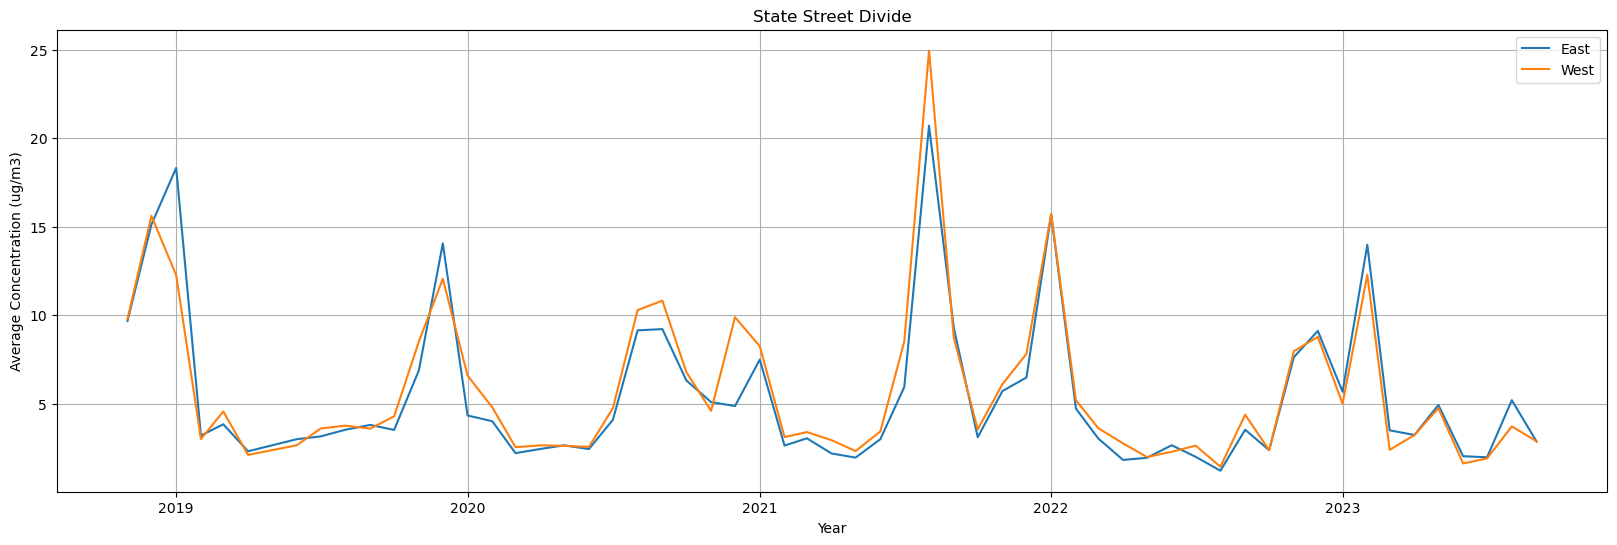


As you can see, there isn't a huge difference, but still something to explore.

We also wanted to see if there is a difference in air quality in regards to elevation so we made a scatterplot with alpha = .01 because of how many points there were.

In [30]:
# # SLC's elevation is 4265ft (1300 meters)

# # just going to rule out any obvious outliers
# elevationDF = df[df['Elevation_m'] < 1400][df['Elevation_m'] > 1200]

# plt.scatter(elevationDF['Elevation_m'], elevationDF['ES642_PM2.5_Concentration_ug/m3'], alpha = .01, color='red')
# plt.title('Scatter Plot of ES642_PM2.5_Concentration vs. Elevation')
# plt.xlabel('Elevation (m)')
# plt.ylabel('ES642_PM2.5_Concentration_ug/m3')
# plt.show()

#### 4.2 Air Quality Monitored by TRAX, Aggregated by Distance Along the TRAX Infrastructure and Season

We are interested in seeing how air quality varies along the TRAX infrastructure, representing cross sections of the Salt Lake Valley. We aggregated the data by distance along the TRAX infrastructure and season. As an example below, we aggregated the data for TRAX train 1 (TRX01) by distance along the TRAX infrastructure and season. We then plotted PM2.5 concentration data as a line graph.

In [31]:
transit_df = pd.read_csv('./data/transit_dfs/TRX01_df.csv', low_memory=False, header=1)

transit_overall_df = transit_df.groupby(['Latitude_ddeg', 'Longitude_ddeg'])

transit_summer_df = transit_df[transit_df['Month'].isin([4, 5, 6, 7, 8])]
transit_summer_df = transit_summer_df.groupby(['Latitude_ddeg', 'Longitude_ddeg'])

transit_winter_df = transit_df[transit_df['Month'].isin([10, 11, 12, 1, 2, 3])]
transit_winter_df = transit_winter_df.groupby(['Latitude_ddeg', 'Longitude_ddeg'])

In [32]:
pm25_avg = transit_overall_df['ES642_PM2.5_Concentration_ug/m3'].mean()
pm25_avg = pm25_avg.reset_index()
pm25_avg_ns = pm25_avg.sort_values(by='Latitude_ddeg', ascending=True)
pm25_avg_ns['State_St_Long'] = -111.888245

summer_pm25_avg = transit_summer_df['ES642_PM2.5_Concentration_ug/m3'].mean()
summer_pm25_avg = summer_pm25_avg.reset_index()
summer_pm25_avg_ns = summer_pm25_avg.sort_values(by='Latitude_ddeg', ascending=True)
summer_pm25_avg_ns['State_St_Long'] = -111.888245

winter_pm25_avg = transit_winter_df['ES642_PM2.5_Concentration_ug/m3'].mean()
winter_pm25_avg = winter_pm25_avg.reset_index()
winter_pm25_avg_ns = winter_pm25_avg.sort_values(by='Latitude_ddeg', ascending=True)
winter_pm25_avg_ns['State_St_Long'] = -111.888245

In [33]:
pm25_avg_ns['Distance_km'] = pm25_avg_ns.apply(lambda row: geodesic((pm25_avg_ns['Latitude_ddeg'].iloc[0], -111.888245), (row['Latitude_ddeg'], row['State_St_Long'])).km, axis=1)
pm25_avg_ns['Distance_Bin'] = pd.cut(pm25_avg_ns['Distance_km'], bins=np.arange(pm25_avg_ns['Distance_km'].min(), pm25_avg_ns['Distance_km'].max() + 0.1, 0.1))

summer_pm25_avg_ns['Distance_km'] = summer_pm25_avg_ns.apply(lambda row: geodesic((summer_pm25_avg_ns['Latitude_ddeg'].iloc[0], -111.888245), (row['Latitude_ddeg'], row['State_St_Long'])).km, axis=1)
summer_pm25_avg_ns['Distance_Bin'] = pd.cut(summer_pm25_avg_ns['Distance_km'], bins=np.arange(summer_pm25_avg_ns['Distance_km'].min(), summer_pm25_avg_ns['Distance_km'].max() + 0.1, 0.1))

winter_pm25_avg_ns['Distance_km'] = winter_pm25_avg_ns.apply(lambda row: geodesic((winter_pm25_avg_ns['Latitude_ddeg'].iloc[0], -111.888245), (row['Latitude_ddeg'], row['State_St_Long'])).km, axis=1)
winter_pm25_avg_ns['Distance_Bin'] = pd.cut(winter_pm25_avg_ns['Distance_km'], bins=np.arange(winter_pm25_avg_ns['Distance_km'].min(), winter_pm25_avg_ns['Distance_km'].max() + 0.1, 0.1))

In [34]:
pm25_avg_ns_dist = pm25_avg_ns.groupby(['Distance_Bin'])['ES642_PM2.5_Concentration_ug/m3'].mean()
pm25_avg_ns_dist = pm25_avg_ns_dist.reset_index()
pm25_avg_ns_dist['Distance_Bin_First'] = pm25_avg_ns_dist['Distance_Bin'].apply(lambda x: x.left)

summer_pm25_avg_ns_dist = summer_pm25_avg_ns.groupby(['Distance_Bin'])['ES642_PM2.5_Concentration_ug/m3'].mean()
summer_pm25_avg_ns_dist = summer_pm25_avg_ns_dist.reset_index()
summer_pm25_avg_ns_dist['Distance_Bin_First'] = summer_pm25_avg_ns_dist['Distance_Bin'].apply(lambda x: x.left)

winter_pm25_avg_ns_dist = winter_pm25_avg_ns.groupby(['Distance_Bin'])['ES642_PM2.5_Concentration_ug/m3'].mean()
winter_pm25_avg_ns_dist = winter_pm25_avg_ns_dist.reset_index()
winter_pm25_avg_ns_dist['Distance_Bin_First'] = winter_pm25_avg_ns_dist['Distance_Bin'].apply(lambda x: x.left)

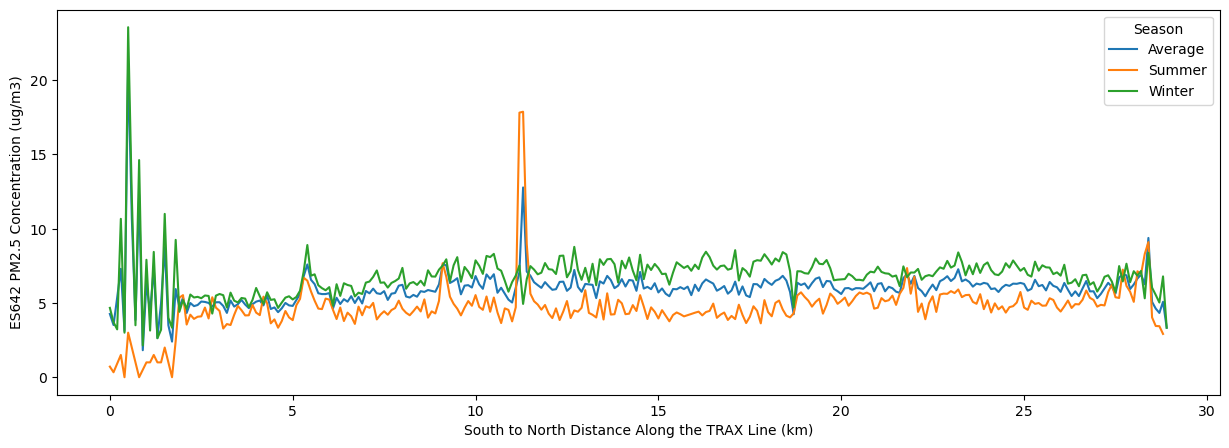

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(ax=ax, data=pm25_avg_ns_dist, x='Distance_Bin_First', y='ES642_PM2.5_Concentration_ug/m3', label='Average')
sns.lineplot(ax=ax, data=summer_pm25_avg_ns_dist, x='Distance_Bin_First', y='ES642_PM2.5_Concentration_ug/m3', label='Summer')
sns.lineplot(ax=ax, data=winter_pm25_avg_ns_dist, x='Distance_Bin_First', y='ES642_PM2.5_Concentration_ug/m3', label='Winter')
ax.set_xlabel('South to North Distance Along the TRAX Line (km)')
ax.set_ylabel('ES642 PM2.5 Concentration (ug/m3)')
ax.legend(title='Season')

In [36]:
slc_shapefile_path = 'zcta_data/slc_zcta.shp'
slc_gdf = gpd.read_file(slc_shapefile_path)
slc_gdf.to_crs(epsg=4326, inplace=True)
slc_gdf.head()

trax01_df = pd.read_csv('./data/transit_dfs/TRX01_df.csv', low_memory=False, header=1)
trax02_df = pd.read_csv('./data/transit_dfs/TRX02_df.csv', low_memory=False, header=1)
trax03_df = pd.read_csv('./data/transit_dfs/TRX03_df.csv', low_memory=False, header=1)
bus01_df = pd.read_csv('./data/transit_dfs/BUS01_df.csv', low_memory=False, header=1)
bus02_df = pd.read_csv('./data/transit_dfs/BUS02_df.csv', low_memory=False, header=1)
bus03_df = pd.read_csv('./data/transit_dfs/BUS03_df.csv', low_memory=False, header=1)
bus04_df = pd.read_csv('./data/transit_dfs/BUS04_df.csv', low_memory=False, header=1)
bus05_df = pd.read_csv('./data/transit_dfs/BUS05_df.csv', low_memory=False, header=1)
bus06_df = pd.read_csv('./data/transit_dfs/BUS06_df.csv', low_memory=False, header=1)
bus07_df = pd.read_csv('./data/transit_dfs/BUS07_df.csv', low_memory=False, header=1)

concat_list = [trax01_df, trax02_df, trax03_df, bus01_df, bus02_df, bus03_df, bus04_df, bus05_df, bus06_df, bus07_df]

transit_df = pd.concat(concat_list, ignore_index=True)
# transit_df = transit_df[transit_df['Date'] == '2021-08-06']
transit_df.head()

transit_df['Point'] = gpd.GeoSeries([Point(xy) for xy in zip(transit_df['Longitude_ddeg'], transit_df['Latitude_ddeg'])])
transit_df.head(10)

transit_gdf = gpd.GeoDataFrame(transit_df, geometry='Point', crs='epsg:4326')
transit_gdf.head()
transit_slc_gdf = gpd.sjoin(transit_gdf, slc_gdf, how="left", predicate='within')
# transit_slc_gdf = transit_slc_gdf[transit_slc_gdf['Date'] == '2021-08-06']
transit_slc_gdf.head()

transit_avg_zcta = transit_slc_gdf.groupby('ZCTA5')['ES642_PM2.5_Concentration_ug/m3'].mean()
transit_avg_zcta = transit_avg_zcta.reset_index()
transit_avg_zcta['ZCTA5'] = transit_avg_zcta['ZCTA5'].astype(int)

transit_avg_zcta.head()

slc_zcta_list_path = './zcta_data/slc_zcta.csv'

slc_zcta_list = []

with open(slc_zcta_list_path, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        int_row = [int(i) for i in row]
        slc_zcta_list.append(int_row)
        
slc_zcta_list = [item for sublist in slc_zcta_list for item in sublist]

house_value_path = './data/census_data/median_house_value_df.csv'
house_value_df = pd.read_csv(house_value_path)
house_value_df = house_value_df[house_value_df['ZCTA5'].isin(slc_zcta_list)]
house_value_df.columns = house_value_df.columns.str.strip()
house_value_df = house_value_df.replace(',','', regex=True)
house_value_df = house_value_df.replace('-', np.nan)
house_value_df = house_value_df.rename(columns={'Median value (dollars)': 'Median_House_Value'})
house_value_df['Median_House_Value'] = house_value_df['Median_House_Value'].astype(float)
house_value_df = house_value_df.reset_index(drop=True)

house_value_df.head()

if isinstance(transit_avg_zcta, pd.Series):
    transit_avg_zcta = transit_avg_zcta.to_frame()

# # Merge transit_slc_gdf and transit_avg_zcta
# merged_df = transit_slc_gdf.merge(transit_avg_zcta, on='ZCTA5')

# Merge merged_df and house_value_df
transit_socioecon = transit_avg_zcta.merge(house_value_df, on='ZCTA5')

transit_socioecon.head(20)
import matplotlib.pyplot as plt

plt.scatter(transit_socioecon['Median_House_Value'], transit_socioecon['ES642_PM2.5_Concentration_ug/m3'])
plt.xlabel('Median House Value')
plt.ylabel('PM2.5 Concentration')
plt.title('Concentration vs Median House Value')
plt.show()

#### 4.3 Interactive Map Combining Air Quality Data with Socioeconomic Demographic Data

#### 4.3.1 Read in transit_dfs

In [37]:
trax01_temp_df = pd.read_csv('./data/transit_dfs/TRX01_df.csv', low_memory=False, header=1)
trax02_temp_df = pd.read_csv('./data/transit_dfs/TRX02_df.csv', low_memory=False, header=1)
trax03_temp_df = pd.read_csv('./data/transit_dfs/TRX03_df.csv', low_memory=False, header=1)
bus01_temp_df = pd.read_csv('./data/transit_dfs/BUS01_df.csv', low_memory=False, header=1)
bus02_temp_df = pd.read_csv('./data/transit_dfs/BUS02_df.csv', low_memory=False, header=1)
bus03_temp_df = pd.read_csv('./data/transit_dfs/BUS03_df.csv', low_memory=False, header=1)
bus04_temp_df = pd.read_csv('./data/transit_dfs/BUS04_df.csv', low_memory=False, header=1)
bus05_temp_df = pd.read_csv('./data/transit_dfs/BUS05_df.csv', low_memory=False, header=1)
bus06_temp_df = pd.read_csv('./data/transit_dfs/BUS06_df.csv', low_memory=False, header=1)
bus07_temp_df = pd.read_csv('./data/transit_dfs/BUS07_df.csv', low_memory=False, header=1)

#### 4.3.2 Selecting and Exploring Bad Air Days

These days were selected through a combination of searching through media to find historically bad air quality days. The intent was to see how air quality varied spacially across the valley with different types of bad air quality events--fire, dust, inversion. The findings were not as clear as we thought they would be in terms of showing significantly worse air quality on the West side vs the East. The sheer amount of data points definitely inhibited visualizing and exploring these events and this is a part of the project that we would like to continue exploring as the project continues. This is a key part of the story portion of our project, so this will be time well spent.

In [38]:
### Load the AQ data into df ###

""" trax01_temp_df = trax01_df[trax01_df['Date'] == investigate_date].reset_index()
trax02_temp_df = trax02_df[trax02_df['Date'] == investigate_date].reset_index()
trax03_temp_df = trax03_df[trax03_df['Date'] == investigate_date].reset_index()
bus01_temp_df = bus01_df[bus01_df['Date'] == investigate_date].reset_index()
bus02_temp_df = bus02_df[bus02_df['Date'] == investigate_date].reset_index()
bus03_temp_df = bus03_df[bus03_df['Date'] == investigate_date].reset_index()
bus04_temp_df = bus04_df[bus04_df['Date'] == investigate_date].reset_index()
bus05_temp_df = bus05_df[bus05_df['Date'] == investigate_date].reset_index()
bus06_temp_df = bus06_df[bus06_df['Date'] == investigate_date].reset_index()
bus07_temp_df = bus07_df[bus07_df['Date'] == investigate_date].reset_index() """

concat_list = [trax01_temp_df, trax02_temp_df, trax03_temp_df, bus01_temp_df, bus02_temp_df, bus03_temp_df, bus04_temp_df, bus05_temp_df, bus06_temp_df, bus07_temp_df]

concat_df = pd.concat(concat_list, ignore_index=True)

AQI_category = CategoricalDtype(categories=["Good", "Moderate", "Unhealthy for Sensitive Groups", 
                                            "Unhealthy", "Very Unhealthy", "Hazardous"], ordered=True)
PM25_Category = CategoricalDtype(categories=["< 12.00", "12.00 - 35.50", "35.50 - 85.50", 
                                                "115.00 - 150.50", "150.50+"], ordered=True)
MesoWest_Category = CategoricalDtype(categories=['< 2.00', '2.00 - 4.00', '4.00 - 6.00', 
                                                    '6.00 - 8.00', '8.00 - 10.00','10.00 - 12.00',
                                                    '12.00 - 20.00','20.00 - 28.00','28.00 - 35.50',
                                                    '35.50 - 45.50','45.50 - 55.50','55.50 - 85.50',
                                                    '85.50 - 115.50','115.50 - 150.50','150.50+'], ordered=True)

concat_df['AQI'] = concat_df['AQI'].astype(AQI_category)
concat_df['PM2.5_Category'] = concat_df['PM2.5_Category'].astype(PM25_Category)
concat_df['Meso_West_Category'] = concat_df['Meso_West_Category'].astype(MesoWest_Category)

#rename columns
concat_df.rename(columns={'Meso_West_Category': 'PM2.5_Concentration_(ug/m3)'}, inplace=True)
median_hh_income_gdf.rename(columns={'Median_HH_Income': 'Median_Household_Income'}, inplace=True)
race_pop_gdf.rename(columns={'Perc_NonWhite': 'Percent_Minority_Population'}, inplace=True)

geo_df = gpd.GeoDataFrame(
    concat_df,
    geometry=gpd.points_from_xy(concat_df.Longitude_ddeg, concat_df.Latitude_ddeg),
    crs='EPSG:4326'
)

### *Revised PM2.5 Averages Over Time Maps*

/var/folders/15/1m9vwy156194hh305hlh4b4w0000gn/T/ipykernel_62591/1668307638.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  westBin = df[df['Longitude_ddeg'] <= -111.904736][df['Latitude_ddeg'] >= 40.633707]#west valley bin
/var/folders/15/1m9vwy156194hh305hlh4b4w0000gn/T/ipykernel_62591/1668307638.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eastBin = df[df['Longitude_ddeg'] >= -111.904736][df['Latitude_ddeg'] >= 40.633707]#east bench bin


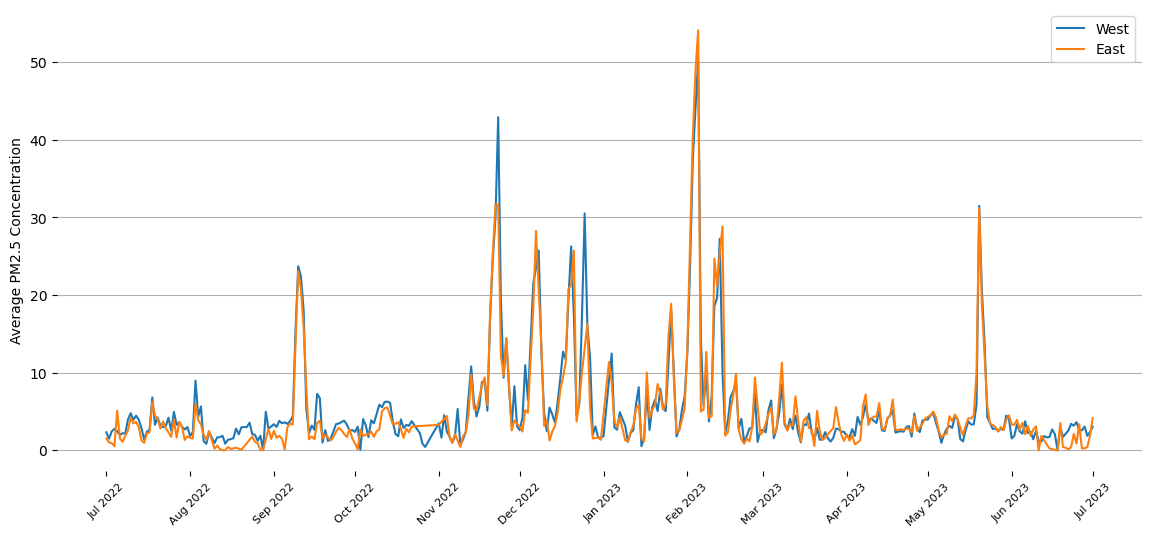

In [39]:
from matplotlib.dates import MonthLocator, DateFormatter

df = concat_df
# westBin = df[df['Longitude_ddeg'] <= -111.888245][df['Longitude_ddeg'] >= -112.037638][df['Latitude_ddeg'] >= 40.660287][df['Latitude_ddeg'] <= 40.771445] #west valley bin
# eastBin = df[df['Longitude_ddeg'] <= -111.829276][df['Longitude_ddeg'] >= -111.888034][df['Latitude_ddeg'] >= 40.662768][df['Latitude_ddeg'] <= 40.778714] #east bench bin
westBin = df[df['Longitude_ddeg'] <= -111.904736][df['Latitude_ddeg'] >= 40.633707]#west valley bin
eastBin = df[df['Longitude_ddeg'] >= -111.904736][df['Latitude_ddeg'] >= 40.633707]#east bench bin

plt.figure(figsize=(14, 6))
def plot_dataframe(df, label):
    # Convert 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Filter data for the specified date range (July 2022 to July 2023)
    start_date = '2022-07-01'
    end_date = '2023-07-01'
    filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    # Group by 'Date' and calculate the average of 'ES642_PM2.5_Concentration_ug/m3'
    daily_avg = filtered_df.groupby('Date')['ES642_PM2.5_Concentration_ug/m3'].mean().reset_index()

    # Plot the line for the given dataframe
    plt.plot(daily_avg['Date'], daily_avg['ES642_PM2.5_Concentration_ug/m3'], linestyle='-', label=label)

plot_dataframe(westBin, label='West')
plot_dataframe(eastBin, label='East')
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks(fontsize=8)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend()
plt.ylabel('Average PM2.5 Concentration')
plt.show()

In [40]:
date_to_plot = '2022-01-13'
filtered_westBin = westBin[westBin['Date'] == date_to_plot]
filtered_eastBin = eastBin[eastBin['Date'] == date_to_plot]

plt.figure(figsize=(12, 8))
sns.lineplot(x='Hour', y='ES642_PM2.5_Concentration_ug/m3', data=filtered_westBin, label='West')
sns.lineplot(x='Hour', y='ES642_PM2.5_Concentration_ug/m3', data=filtered_eastBin, label='East')

plt.title('Average PM2.5 Concentration by hour for January 13, 2022')
plt.ylabel('PM2.5 Value')
plt.xlabel('')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks([0, 6, 12, 18, 23], ['Midnight', '6 AM', 'Noon', '6 PM', '11 PM'])
plt.xlim(-.5, 23.5)

plt.show()

In [41]:
date_to_plot = '2022-01-14'
filtered_westBin = westBin[westBin['Date'] == date_to_plot]
filtered_eastBin = eastBin[eastBin['Date'] == date_to_plot]

plt.figure(figsize=(12, 8))
sns.lineplot(x='Hour', y='ES642_PM2.5_Concentration_ug/m3', data=filtered_westBin, label='West')
sns.lineplot(x='Hour', y='ES642_PM2.5_Concentration_ug/m3', data=filtered_eastBin, label='East')

plt.title('Average PM2.5 Concentration by hour for January 14, 2022')
plt.ylabel('PM2.5 Value')
plt.xlabel('')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks([0, 6, 12, 18, 23], ['Midnight', '6 AM', 'Noon', '6 PM', '11 PM'])
plt.xlim(-.5, 23.5)

plt.show()

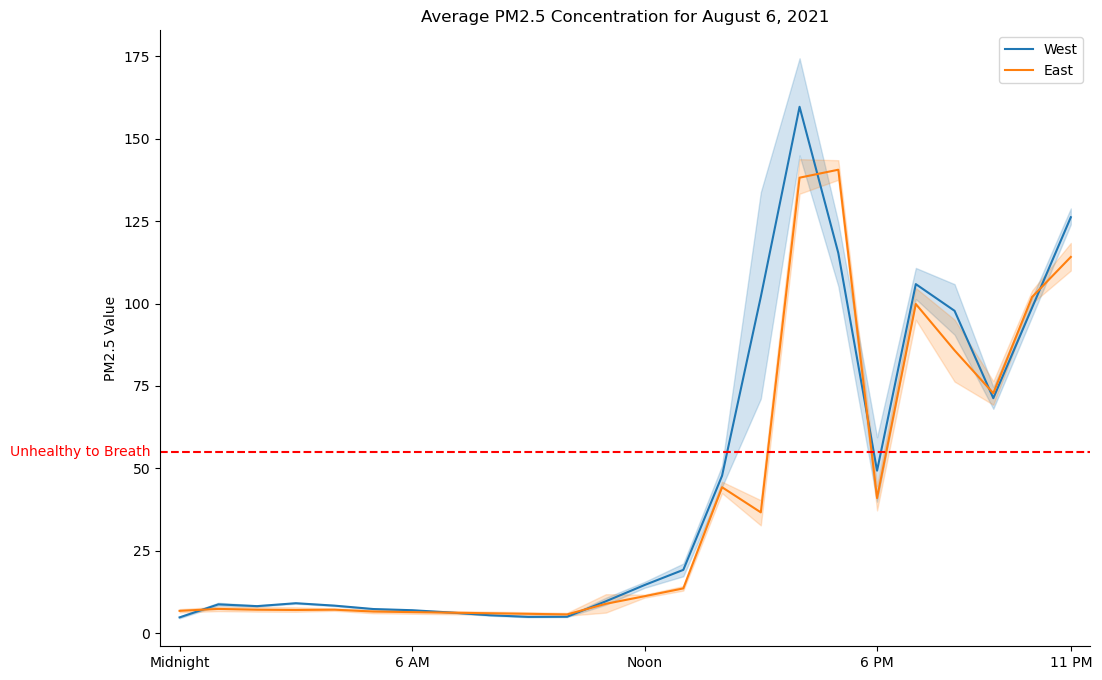

In [42]:
date_to_plot = '2021-08-06'
filtered_westBin = westBin[westBin['Date'] == date_to_plot]
filtered_eastBin = eastBin[eastBin['Date'] == date_to_plot]

plt.figure(figsize=(12, 8))
sns.lineplot(x='Hour', y='ES642_PM2.5_Concentration_ug/m3', data=filtered_westBin, label='West')
sns.lineplot(x='Hour', y='ES642_PM2.5_Concentration_ug/m3', data=filtered_eastBin, label='East')

plt.axhline(y=55, color='red', linestyle='--', label='Threshold')
plt.text(-.75, 55, 'Unhealthy to Breath', color='red', ha='right', va='center')

plt.title('Average PM2.5 Concentration for August 6, 2021')
plt.ylabel('PM2.5 Value')
plt.xlabel('')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks([0, 6, 12, 18, 23], ['Midnight', '6 AM', 'Noon', '6 PM', '11 PM'])
plt.xlim(-.5, 23.5)
plt.show()

#### 4.3.3 Overlaying Air Quality Data over Socioeconomic Data | Matplotlib

In [43]:
### Set Date(s) to Plot ###

## INVERSION -- Bad Air day from initial explore of dataset -- solid East/West discrepancy - INVERSION?
inversion1_date = "2022-01-13" 
inversion1_df = geo_df[geo_df['Date'] == inversion1_date]
inversion1_df = inversion1_df[inversion1_df['Hour'] < 15]

## INVERSION -- Bad Air day from initial explore of dataset -- solid East/West discrepancy - INVERSION?
inversion2_date = "2022-01-14" 
inversion2_df = geo_df[geo_df['Date'] == inversion2_date]
inversion2_df = inversion2_df[inversion2_df['Hour'] < 14]

## SMOKE --Solid example of west/east discrepancy with bad SMOKE in the air
smoke_date = '2021-08-06' 
smoke_df = geo_df[geo_df['Date'] == smoke_date]
smoke_df = smoke_df[smoke_df['Hour'] > 18]

In [44]:
### Overlay AQ data on Income data ###

from palettable.cmocean.sequential import Matter_15
cmap=ListedColormap((Matter_15).mpl_colors)


fig, ax = plt.subplots(figsize=(7,7))

""" race_pop_gdf.plot(
    ax=ax,
    column='Percent_Minority_Population',
    cmap='Purples', 
    linewidth=0.8, 
    edgecolor='0.8', 
    legend=True) """

median_hh_income_gdf.plot(
    ax=ax,
    column='Median_Household_Income', 
    cmap='Greens', 
    linewidth=0.8, 
    edgecolor='0.8', 
    legend=True,
    legend_kwds={'shrink': .5}
    )

inversion1_df.plot(
    ax=ax,
    column='PM2.5_Concentration_(ug/m3)',
    cmap=cmap,
    legend=True,
    #move location of legend
    legend_kwds={'loc': 'lower right', 'bbox_to_anchor': (1.68, 0)},
)


## Full Salt Lake County ##
plt.xlim(-112.3, -111.5)
plt.ylim(40.4, 40.9)

""" ## Downtown Salt Lake ##
plt.xlim(-112.03, -111.78)
plt.ylim(40.67, 40.8)
"""
 
#plt.xticks([])
#plt.yticks([])

' ## Downtown Salt Lake ##\nplt.xlim(-112.03, -111.78)\nplt.ylim(40.67, 40.8)\n'

This was the first attempt at overlaying the AQ data on the socioeconomic data. Worked great as a proof of concept, but definitely leaves a lot to be desired both aesthecially and functionally. We also explored the idea of a more zoomed-in view of the data to focus on the part of the valley where the East-West inequalities are more present and where we have much more East-West AQ data from TRAX going from the University out to the airport.

#### 4.3.4 Overlaying Air Quality Data over Socioeconomic Data | GeoPandas + Folium

To improve on the above visualization, we decided to use the GeoPandas.explore() function to get an interactive map.

This allows us to:
* Zoom and Pan
* Choose the socioeconomic base map
* Display a better legend
* Include a clean and simple base map under all of the data

In [45]:
### Plot Interactive Map ###

from scipy.__config__ import show


Meso_West_cmap = ['#00FFFF','#00CCFF','#0099FF','#00FF00','#009900','#006600','#FFFF00','#FFE600','#FFCD00','#FF7E00','#FF5000','#FF0000','#990000','#CC0033','#FF00FF']

""" m = race_pop_gdf.explore(
    column='Percent_Minority_Population', 
    cmap='Purples', 
    tooltip=False,
    #tiles="CartoDB positron",
    tiles=None,
    style_kwds={'fillOpacity': 0.4, 'weight': 1, 'color': 'black'},
    popup=['Percent_Minority_Population'],
    highlight=False,
    name='Percent Minority Population',
    overlay=False,
) """

""" income = median_hh_income_gdf.explore(
    m=m,
    column='Median_Household_Income', 
    cmap='Greens_r', 
    tooltip=False,
    #tiles="CartoDB positron",
    tiles=None,
    style_kwds={'fillOpacity': 0.4, 'weight': 1, 'color': 'black'},
    popup=['Median_Household_Income'],
    highlight=False,
    show=False,
    name='Median Household Income',
    overlay=False,
) """

""" house_value = house_value_gdf.explore(
    m=m,
    column='Median_House_Value', 
    cmap='Oranges_r', 
    tooltip=False,
    #tiles="CartoDB positron",
    tiles=None,
    style_kwds={'fillOpacity': 0.4, 'weight': 1, 'color': 'black'},
    popup=['Median_House_Value'],
    highlight=False,
    show=False,
    name='Median House Value',
    overlay=False,
)
"""  """
per_cap_income = per_cap_income_gdf.explore(
    m=m,
    column='Per_Capita_Income_Value', 
    cmap='YlGnBu_r', 
    tooltip=False,
    #tiles="CartoDB positron",
    tiles=None,
    style_kwds={'fillOpacity': 0.4, 'weight': 1, 'color': 'black'},
    popup=['ZCTA5', 'Per_Capita_Income_Value'],
    highlight=False,
    show=False,
    name='Per Capita Income',
    overlay=False,
) """

""" hispanic_latino = race_pop_gdf.explore(
    m=m,
    column='Perc_Hispanic_Latino', 
    cmap='Blues', 
    tooltip=False,
    #tiles="CartoDB positron",
    tiles=None,
    style_kwds={'fillOpacity': 0.4, 'weight': 1, 'color': 'black'},
    popup=['ZCTA5', 'Perc_Hispanic_Latino'],
    highlight=False,
    name='Percent Hispanic/Latino',
    overlay=False,
) """

""" black_pop = race_pop_gdf.explore(
    m=m,
    column='Perc_Black', 
    cmap='Greens', 
    tooltip=False,
    #tiles="CartoDB positron",
    tiles=None,
    style_kwds={'fillOpacity': 0.4, 'weight': 1, 'color': 'black'},
    popup=['ZCTA5', 'Perc_Black'],
    highlight=False,
    name='Percent Black',
    overlay=False,
) """

""" smoke_data = smoke_df.explore(
    m=m,
    #column='AQI',
    column='PM2.5_Concentration_(ug/m3)',
    #column='PM2.5_Category',
    #column='ES642_PM2.5_Concentration_ug/m3',
    #cmap=['green', 'yellow', 'orange', 'red', 'purple', 'maroon'],
    cmap=Meso_West_cmap,
    marker_type='circle_marker',
    marker_kwds={'radius': 5, 'fill': True, 'alpha': 1},
    style_kwds={'fillOpacity': 1, 'weight': 1, 'color': 'black'},
    tooltip=['ES642_PM2.5_Concentration_ug/m3','AQI', 'PM2.5_Concentration_(ug/m3)','Timestamp_UTC', 'Transit_ID','Hour'],
    #tiles="CartoDB positron",
    tiles=None,
    name='Wildfire Smoke (Aug. 6, 2021)',
    overlay=True,
    #control=False,
    show=False,
) """

m = inversion1_df.explore(
    #m=m,
    #column='AQI',
    column='PM2.5_Concentration_(ug/m3)',
    #column='PM2.5_Category',
    #column='ES642_PM2.5_Concentration_ug/m3',
    #cmap=['green', 'yellow', 'orange', 'red', 'purple', 'maroon'],
    cmap=Meso_West_cmap,
    marker_type='circle_marker',
    marker_kwds={'radius': 5, 'fill': True, 'alpha': 1},
    style_kwds={'fillOpacity': 1, 'weight': 1, 'color': 'black'},
    tooltip=['ES642_PM2.5_Concentration_ug/m3','AQI', 'PM2.5_Concentration_(ug/m3)','Timestamp_UTC', 'Transit_ID','Hour'],
    #tiles="CartoDB positron",
    tiles=None,
    name='Inversion (Jan. 13, 2022)',
    overlay=True,
    #control=False,
    show=True,
)
""" inversion2 = inversion2_df.explore(
    m=m,
    #column='AQI',
    column='PM2.5_Concentration_(ug/m3)',
    #column='PM2.5_Category',
    #column='ES642_PM2.5_Concentration_ug/m3',
    #cmap=['green', 'yellow', 'orange', 'red', 'purple', 'maroon'],
    cmap=Meso_West_cmap,
    marker_type='circle_marker',
    marker_kwds={'radius': 5, 'fill': True, 'alpha': 1},
    style_kwds={'fillOpacity': 1, 'weight': 1, 'color': 'black'},
    tooltip=['ES642_PM2.5_Concentration_ug/m3','AQI', 'PM2.5_Concentration_(ug/m3)','Timestamp_UTC', 'Transit_ID','Hour'],
    #tiles="CartoDB positron",
    tiles=None,
    name='Inversion (Jan. 14, 2022)',
    overlay=True,
    #control=False,
    show=False,
) """

#m.keep_in_front(smoke_data, inversion_data)

folium.raster_layers.TileLayer(tiles='CartoDB positron', name='CartoDB positron', control=False).add_to(m)

#folium.LayerControl(collapsed = False, ).add_to(m) 

m

#m.save("interactiveMapTest.html")

This is the working prototype of the interactive map.

There's also plenty that we'd like to add/change: 
* Socioeconomic base map legends only showing for which layer is visible
* More clear region labels on the map
* AQ data points never being underneath base maps
* Zoom limits
* Date/AQ event selector within the map instead of through code